# Training a Neural Network for Computer Model Emulation

### Import necessary libraries 

In [1]:
%matplotlib inline
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')

import seaborn as sns
sns.set()
from pandas.plotting import scatter_matrix
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
from calculations_load import *
from configurations import *

Using idf = 0 : Grad
SystemsInfo = 
{'Pb-Pb-2760': {'proj': 'Pb', 'targ': 'Pb', 'sqrts': 2760, 'main_design_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_main_PbPb-2760.dat', 'main_range_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_ranges_main_PbPb-2760.dat', 'validation_design_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_validation_PbPb-2760.dat', 'validation_range_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production//design_ranges_validation_PbPb-2760.dat', 'main_events_dir': 'model_calculations/production_500pts_Pb_Pb_2760/Events/main', 'validation_events_dir': 'model_calculations/production_500pts_Pb_Pb_2760/Events/validation', 'main_obs_file': 'model_calculations/production_500pts_Pb_Pb_2760/Obs/main.dat', 'validation_obs_file': 'model_calculations/production_500pts_Pb_Pb_2760/Obs/validation.dat', 'n_design': 500, 'n_validation': 100, 'design_remove_idx': [289, 483, 32

In [4]:
#prepare the directories for model design and outputs
#run this cell only once, or else it will hang!
#! sh prepare.sh

### Loading Computer Model inputs and outputs

In [5]:
system_str = 'Pb-Pb-2760'
design_file = 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_main_PbPb-2760.dat'
design = pd.read_csv(design_file)
design = design.drop("idx", axis=1)

#delete bad design points
drop_indices = list(delete_design_pts_set)
design = design.drop(drop_indices)

#choose features (inputs)
#feature_cols = ['norm', 'trento_p'] #specific choices
feature_cols = design.keys().values #all of them 
n_features = len(feature_cols)

X = design[feature_cols]

n_design = SystemsInfo["Pb-Pb-2760"]["n_design"]
npt = n_design - len(delete_design_pts_set)
obs = 'dNch_deta' #choose the observable we want to emulate

Y = np.array([])

for pt in range(npt):
    for obs in active_obs_list['Pb-Pb-2760']:
        Y = np.append( Y, trimmed_model_data[system_str][pt, idf][obs]['mean'][:], axis=0)
        
Y = Y.reshape(X.shape[0], -1)

In [6]:
print( "X.shape : "+ str(X.shape) )
print( "Y.shape : "+ str(Y.shape) )

X.shape : (485, 17)
Y.shape : (485, 110)


## Splitting the inputs and outputs into a training and testing set

Then, scaling all of the inputs and outputs to (0, 1)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)

X_scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_train)
Y_scaler = MinMaxScaler(feature_range=(-1, 1)).fit(Y_train)

X_train_sc = X_scaler.transform(X_train)
X_test_sc = X_scaler.transform(X_test)

Y_train_sc = Y_scaler.transform(Y_train)
Y_test_sc = Y_scaler.transform(Y_test)

### The cell below constructs the neural network

In [8]:
from keras.models import Model

n_neur = 30 #number of neurons on hidden layers
#n_hidden = 3 # number of hidden layers
dropout_rate = 0.5 # the layer dropout rate 

def build_model():
    inputs = layers.Input(shape=(X.shape[1],))
    x = layers.Dense(n_neur, activation='tanh')(inputs)
    x = layers.Dense(n_neur, activation='tanh')(inputs)
    x = layers.Dropout(dropout_rate)(x, training=True)
    x = layers.Dense(Y.shape[1], activation='tanh')(x)
    outputs = x
    model = Model(inputs, outputs)
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

model = build_model()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 17)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                540       
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 110)               3410      
Total params: 3,950
Trainable params: 3,950
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.fit(X_train_sc, Y_train_sc, epochs=500, batch_size=20)

Epoch 1/500
20/20 [==============================] - 0s 1ms/step - loss: 0.2969 - accuracy: 0.0103
Epoch 2/500
20/20 [==============================] - 0s 1ms/step - loss: 0.2565 - accuracy: 0.0155
Epoch 3/500
20/20 [==============================] - 0s 1ms/step - loss: 0.2221 - accuracy: 0.0232
Epoch 4/500
20/20 [==============================] - 0s 1ms/step - loss: 0.1936 - accuracy: 0.0361
Epoch 5/500
20/20 [==============================] - 0s 1ms/step - loss: 0.1672 - accuracy: 0.0464
Epoch 6/500
20/20 [==============================] - 0s 1ms/step - loss: 0.1420 - accuracy: 0.0464
Epoch 7/500
20/20 [==============================] - 0s 1ms/step - loss: 0.1248 - accuracy: 0.0541
Epoch 8/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1011 - accuracy: 0.0773
Epoch 9/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0901 - accuracy: 0.0928
Epoch 10/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0805 - accuracy: 0.0799
Epoch 11/

20/20 [==============================] - 0s 1ms/step - loss: 0.0321 - accuracy: 0.3299
Epoch 84/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0312 - accuracy: 0.2938
Epoch 85/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0327 - accuracy: 0.3247
Epoch 86/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0322 - accuracy: 0.3144
Epoch 87/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0330 - accuracy: 0.3479
Epoch 88/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0328 - accuracy: 0.2526
Epoch 89/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0326 - accuracy: 0.3531
Epoch 90/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0310 - accuracy: 0.3222
Epoch 91/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0311 - accuracy: 0.3093
Epoch 92/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0316 - accuracy: 0.3093
Epoch 93/500


20/20 [==============================] - 0s 2ms/step - loss: 0.0305 - accuracy: 0.3402
Epoch 165/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0314 - accuracy: 0.3222
Epoch 166/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0313 - accuracy: 0.3041
Epoch 167/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0310 - accuracy: 0.3273
Epoch 168/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0313 - accuracy: 0.3067
Epoch 169/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0311 - accuracy: 0.3144
Epoch 170/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0320 - accuracy: 0.3144
Epoch 171/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0301 - accuracy: 0.3067
Epoch 172/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0301 - accuracy: 0.3273
Epoch 173/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0302 - accuracy: 0.3196
Epoc

20/20 [==============================] - 0s 2ms/step - loss: 0.0313 - accuracy: 0.3402
Epoch 246/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0308 - accuracy: 0.3273
Epoch 247/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0309 - accuracy: 0.3402
Epoch 248/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0302 - accuracy: 0.3093
Epoch 249/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0321 - accuracy: 0.3273
Epoch 250/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0337 - accuracy: 0.3144
Epoch 251/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0314 - accuracy: 0.3299
Epoch 252/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0303 - accuracy: 0.3273
Epoch 253/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0341 - accuracy: 0.3119
Epoch 254/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0307 - accuracy: 0.3299
Epoc

20/20 [==============================] - 0s 3ms/step - loss: 0.0327 - accuracy: 0.3531
Epoch 327/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0312 - accuracy: 0.3196
Epoch 328/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0292 - accuracy: 0.2938
Epoch 329/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0305 - accuracy: 0.2809
Epoch 330/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0315 - accuracy: 0.3093
Epoch 331/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0304 - accuracy: 0.3144
Epoch 332/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0311 - accuracy: 0.3015
Epoch 333/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0308 - accuracy: 0.3196
Epoch 334/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0313 - accuracy: 0.2964
Epoch 335/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0313 - accuracy: 0.3505
Epoc

20/20 [==============================] - 0s 1ms/step - loss: 0.0313 - accuracy: 0.2964
Epoch 408/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0316 - accuracy: 0.3196
Epoch 409/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0308 - accuracy: 0.3093
Epoch 410/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0312 - accuracy: 0.3299
Epoch 411/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0307 - accuracy: 0.3119
Epoch 412/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0305 - accuracy: 0.3247
Epoch 413/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0318 - accuracy: 0.2861
Epoch 414/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0307 - accuracy: 0.3582
Epoch 415/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0297 - accuracy: 0.3299
Epoch 416/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0296 - accuracy: 0.3067
Epoc

20/20 [==============================] - 0s 1ms/step - loss: 0.0314 - accuracy: 0.3196
Epoch 489/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0303 - accuracy: 0.3041
Epoch 490/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0300 - accuracy: 0.2835
Epoch 491/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0310 - accuracy: 0.3170
Epoch 492/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0310 - accuracy: 0.3299
Epoch 493/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0318 - accuracy: 0.3041
Epoch 494/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0299 - accuracy: 0.3273
Epoch 495/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0321 - accuracy: 0.3299
Epoch 496/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0320 - accuracy: 0.3222
Epoch 497/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0302 - accuracy: 0.2964
Epoc

In [10]:
predictions = []
nsamples_pred = 500
for t in range(nsamples_pred):
    predictions.append(model.predict(X_test_sc))

pred_array = np.array(predictions)
pred_mean= np.mean(pred_array,axis=0)
pred_std= np.std(pred_array,axis=0)

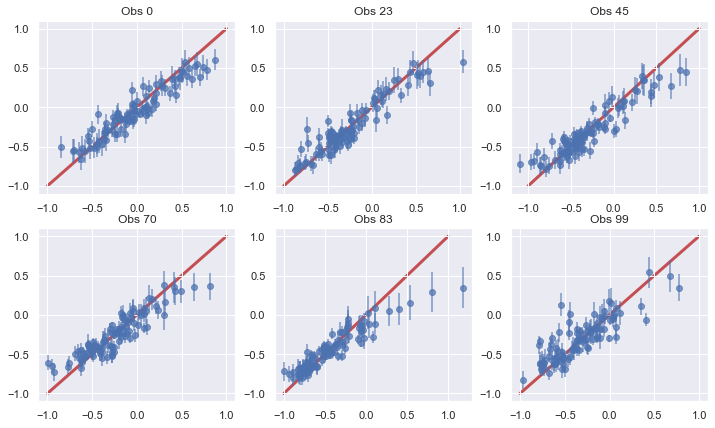

In [11]:
truth = np.linspace(-1, 1, 100)
obs_indices = [0, 23, 45, 70, 83, 99]

fig, axes = plt.subplots(2, 3, figsize=(12, 7))
for i, obs_ind in enumerate(obs_indices):
    ax = axes.flatten()[i]
    ax.set_title("Obs " + str(obs_ind))
    ax.plot(truth, truth, c='r', lw=3, zorder=-1)
    ax.errorbar(Y_test_sc[:, obs_ind], pred_mean[:, obs_ind], yerr=pred_std[:, obs_ind],
                alpha=0.7, zorder=1, fmt='o')